## Severity: Main Modelling

Note: some will not run because the data are not locally present and they need to be downloaded via datalad. 


In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")
import os
os.chdir(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import bambi as bmb
import arviz as az
import json
import pickle
#import cov_model_management as mm
sys.path.append(os.path.join(root_dir, "covid-fear", "lib")) 
import bammm.bammm as mm
import patsy
from IPython import display

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


$$
\alpha
$$

In [2]:
# data import
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))
# hyperparameters
corr_type = "spearman" 
factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
no_trait_factors = 5

if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]


### How traits predict correlation of covid-state-measure and objective severity 

In [3]:
data = df.groupby(by="PROLIFICID")[["PROLIFICID", 'state_severity']+trait_factor_names].mean()

for f in factors:
    data["r_"+f] = np.nan
    for s in df["PROLIFICID"].unique():
        data["r_"+f][s] = df.loc[df["PROLIFICID"].isin([s])][["state_severity", f]].corr(corr_type).loc["state_severity"][f]
data

state_severity  TF1_Worry  TF2_Self_Worth  \
PROLIFICID                                                    
01S0stEpc3rU6YxK        1.154912   0.517251        0.024603   
05c9AaLx1V20UAcO        0.976200   0.625423       -1.667247   
07GDvN1Nh0oHcEBM        0.833057   0.106233       -0.127144   
0OjnLzK5ABd2wO54        0.135050  -2.172855       -1.133754   
0Pe1blVigsBRLvBj        1.316176   0.073350       -0.170443   
...                          ...        ...             ...   
zNbLeZqHa6wNHRLR        0.820558  -0.384059       -1.460161   
zYWr4nlB9BwdVWFB        1.928073   0.208001       -0.224764   
zZGJnUM65XIz0F0X        0.183911  -0.175757       -0.557410   
zlOEoLWEAwlLTGbE        0.354648   0.232104        0.199069   
ztPVSoIVH3QKpGeQ        0.307537   0.318578       -1.573545   

                  TF3_Catastrophizing  TF4_Anxiety  TF5_Depression  \
PROLIFICID                                                           
01S0stEpc3rU6YxK             1.560959    -1.382519       -0.616520   
05c9AaLx1V20UAcO            -0.609047     0.757277        0.957274   
07GDvN1Nh0oHcEBM             0.482953     0.480136       -0.730055   
0OjnLzK5ABd2wO54            -0.296596    -0.293769       -0.037524   
0Pe1blVigsBRLvBj             0.797859     0.540228       -0.315695   
...                               ...          ...             ...   
zNbLeZqHa6wNHRLR            -0.761695     0.095245       -0.812756   
zYWr4nlB9BwdVWFB            -0.009194    -0.604930        1.194719   
zZGJnUM65XIz0F0X            -0.249401    -0.329786       -0.606021   
zlOEoLWEAwlLTGbE             0.870258     0.233356        0.899895   
ztPVSoIVH3QKpGeQ            -0.661175    -0.204080       -0.251562   

                  r_F1_Close_Person_Worry  r_F2_Anxiety_Avoidance  \
PROLIFICID                                                          
01S0stEpc3rU6YxK                 0.076197                0.172968   
05c9AaLx1V20UAcO                -0.347368               -0.524812   
07GDvN1Nh0oHcEBM                -0.424020               -0.191176   
0OjnLzK5ABd2wO54                 0.558105                0.520496   
0Pe1blVigsBRLvBj                 0.170175                0.082456   
...                                   ...                     ...   
zNbLeZqHa6wNHRLR                -0.083616               -0.046704   
zYWr4nlB9BwdVWFB                 0.530827                0.096241   
zZGJnUM65XIz0F0X                 0.210170                0.234275   
zlOEoLWEAwlLTGbE                 0.386466                0.381955   
ztPVSoIVH3QKpGeQ                 0.533133                0.153615   

                  r_F3_Economic_Impact_Worry  r_F4_Prob_Estimates  r_F5_Worry  \
PROLIFICID                                                                      
01S0stEpc3rU6YxK                    0.031241            -0.044956    0.044194   
05c9AaLx1V20UAcO                    0.654135            -0.177444   -0.418045   
07GDvN1Nh0oHcEBM                    0.186275            -0.362745   -0.362745   
0OjnLzK5ABd2wO54                    0.691990             0.518240    0.594208   
0Pe1blVigsBRLvBj                    0.082456            -0.071930   -0.240351   
...                                      ...                  ...         ...   
zNbLeZqHa6wNHRLR                   -0.024106            -0.246328   -0.453485   
zYWr4nlB9BwdVWFB                    0.267669            -0.030075    0.378947   
zZGJnUM65XIz0F0X                   -0.111488            -0.058757    0.084369   
zlOEoLWEAwlLTGbE                    0.630075             0.572932    0.601504   
ztPVSoIVH3QKpGeQ                   -0.078313             0.177711    0.394579   

                  r_F6_Skepticism  
PROLIFICID                         
01S0stEpc3rU6YxK        -0.295645  
05c9AaLx1V20UAcO        -0.096241  
07GDvN1Nh0oHcEBM        -0.215686  
0OjnLzK5ABd2wO54         0.421963  
0Pe1blVigsBRLvBj         0.463158  
...                           ...  
zNbLeZqHa6wNHRLR         0.029379  
zYWr4nlB9Bw

#### look at correlations

<AxesSubplot:>

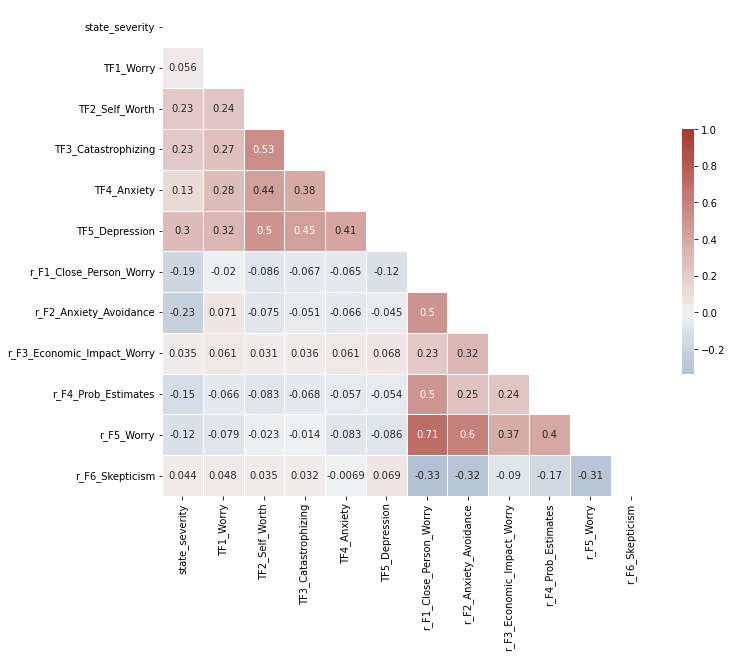

In [4]:

dfl = data.dropna()
# calculate correlation matrix
corr = dfl.corr(corr_type)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", 
                             as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5})


### Model with correlation as DV

$r_{state, severity}$ ... correlation of state severity and covid-related state measure (e.g. covid worry) within participant across time

$$
r_{state, severity} = \beta_0 + \beta_1TF1  + \beta_2TF2 + \beta_3TF3 + \beta_4TF4 + \beta_5TF5 + \beta_6TF6 
$$

**Downside** 
- doesn't distinguish between trait effect and trait\*severity interaction

In [5]:
model_constant = "alltraits"
for f_idx, f in enumerate(factors): 
    dfl = data.loc[:,["r_"+f]+trait_factor_names].dropna()
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    if "F"+str(f_idx+1)+"_"+model_constant+"_2_3000" in models.keys():
        mod = models["F"+str(f_idx+1)+"_"+model_constant+"_2_3000"]
    else:
        mod = mm.get_template()
    mod["type"] = "lmm"
    mod["lmm"]["dep_var"] = "r_"+f
    mod["lmm"]["fxeff"] = trait_factor_names 
    mod["lmm"]["rneff"] = []
    mod["est"]["nchains"] = 2
    mod["est"]["nsamples"] = 3000
    mod["name"] = "F"+str(f_idx+1)+"_"+model_constant+"_"+str(mod["est"]["nchains"])+"_"+str(mod["est"]["nsamples"])
    mod["lmm"]["eq"] = mm.generate_equation(mod["lmm"]["dep_var"], mod["lmm"]["fxeff"], mod["lmm"]["rneff"]) 
    mod["location"] = os.path.join("output", "models", "model_data", "traits_predicting_severity_correlations", mod["name"]+".dic" )
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    mod, res, m = mm.estimate_lmm(mod=mod, data=dfl, override=0)
    models[mod["name"]] = mod
    mm.save_model_info(models, os.path.join(root_dir, "output", "models", "model_database.json"))
    
    
    # PLOT
    tdf = pd.DataFrame()
    for tf in trait_factor_names:
        d = res.posterior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
    # plot the CI97 posterior for the interaction with anxiety
    axs = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs.vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs.axhline(0, alpha=0.2, color='gray')
    axs.set_title("corr of "+f+" and severity")
    axs.set_ylabel("beta (ci95)")
    axs.set_xlabel("")
    axs.set_xticklabels(trait_factor_names, rotation = 30)

Model F1_alltraits_2_3000 already exist, loading it.


KeyError: 'TF1_Worry'

In [ ]:
df

### Model 0: traits + severity + traits * severity + session + (session|ID)
e.g.
$$
Worry \sim  Severity + TF_1 + TF_1*Severity  + TF_2 + TF_2*Severity + session + (session|subject) 
$$

In [ ]:
from IPython import display
#factors_temp = ["F1_Close_Person_Worry"]
model_constant = "severity_onlysession_slope"
estimate1 = 0
if estimate1:
    for f_idx, f in enumerate(factors): 
        dfl = df.loc[:,[f, "state_severity", "PROLIFICID", "session"]+trait_factor_names].dropna()
        models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
        if "F"+str(f_idx+1)+"_"+model_constant+"_2_3000" in models.keys():
            mod = models["F"+str(f_idx+1)+"_"+model_constant+"_2_3000"]
        else:
            mod = mm.get_template()
        mod["type"] = "lmm"
        mod["lmm"]["dep_var"] = f
        mod["lmm"]["fxeff"] = ["state_severity"]+trait_factor_names+['state_severity*'+i for i in trait_factor_names]+["session"]
        mod["lmm"]["rneff"] = ["session|PROLIFICID"]
        mod["est"]["nchains"] = 2
        mod["est"]["nsamples"] = 3000
        mod["est"]["ncores"] = 2
        mod["name"] = "F"+str(f_idx+1)+"_"+model_constant+"_"+str(mod["est"]["nchains"])+"_"+str(mod["est"]["nsamples"])
        mod["lmm"]["eq"] = mm.generate_equation(mod["lmm"]["dep_var"], mod["lmm"]["fxeff"], mod["lmm"]["rneff"]) 
        mod["location"] = os.path.join("output", "models", "model_data", "traits_predicting_severity_correlations", mod["name"]+".dic" )
        mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
        #mod, res, m = mm.estimate_lmm(mod=mod, data=dfl, override=1)
        models[mod["name"]] = mod
        print(mod["lmm"]["eq"])
        #mm.save_model_info(models, os.path.join(root_dir, "output", "models", "model_database.json"))
    



/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F1_severity_onlysession_slope_f5_4_2000.dic
Model F1_severity_onlysession_slope_f5_4_2000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                      0.174  0.008   0.158    0.189      0.001   
TF1_Worry                          -0.020  0.094  -0.205    0.170      0.005   
TF2_Self_Worth                      0.023  0.113  -0.178    0.259      0.008   
TF3_Catastrophizing                 0.263  0.115   0.040    0.475      0.020   
TF4_Anxiety                         0.070  0.102  -0.121    0.286      0.011   
TF5_Depression                      0.035  0.150  -0.211    0.261      0.052   
state_severity:TF1_Worry            0.031  0.011   0.012    0.053      0.002   
state_severity:TF2_Self_Worth      -0.013  0.010  -0.033    0.006      0.001   
state_severity:TF3_Catastrophizing -0.014  0.011  -0.035    0.006      0.002   
state_severity:TF4_Anxiety         -0.024  0.010  -0.043   -0.006      0.001   
state_severity:TF5_Depression      -0.008  0.012  -0.028    0.016      0.002   
session                            -0.012  0.002  -0.015   -0.009      0.000   
1|PROLIFICID_sigma                  1.703  0.063   1.578    1.827      0.003   
session|PROLIFICID_sigma            0.026  0.001   0.024    0.028      0.000   
F1_Close_Person_Worry_sigma         0.324  0.003   0.318    0.330      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.001      75.0    1052.0   1.04  
TF1_Worry                             0.010     318.0     651.0   1.25  
TF2_Self_Worth                        0.009     179.0     396.0   1.11  
TF3_Catastrophizing                   0.014      34.0     524.0   1.09  
TF4_Anxiety                           0.011      87.0     587.0   1.21  
TF5_Depression                        0.038       9.0      76.0   1.38  
state_severity:TF1_Worry              0.001      42.0      26.0   1.07  
state_severity:TF2_Self_Worth         0.000     389.0     567.0   1.03  
state_severity:TF3_Catastrophizing    0.001      33.0     309.0   1.08  
state_severity:TF4_Anxiety            0.000     211.0     401.0   1.01  
state_severity:TF5_Depression         0.001      41.0      43.0   1.06  
session                               0.000      48.0     230.0   1.06  
1|PROLIFICID_sigma                    0.002     437.0     913.0   1.14  
session|PROLIFICID_sigma              0.000     920.0    1348.0   1.07  
F1_Close_Person_Worry_sigma           0.000      75.0     323.0   1.04

/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F2_severity_onlysession_slope_f5_4_2000.dic
Model F2_severity_onlysession_slope_f5_4_2000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                      0.229  0.014   0.203    0.255      0.000   
TF1_Worry                          -0.097  0.275  -0.593    0.408      0.026   
TF2_Self_Worth                      0.172  0.320  -0.411    0.783      0.026   
TF3_Catastrophizing                 0.436  0.277  -0.088    0.953      0.024   
TF4_Anxiety                        -0.064  0.281  -0.596    0.484      0.028   
TF5_Depression                     -0.007  0.319  -0.623    0.605      0.027   
state_severity:TF1_Worry            0.070  0.015   0.042    0.098      0.000   
state_severity:TF2_Self_Worth      -0.016  0.017  -0.048    0.017      0.000   
state_severity:TF3_Catastrophizing -0.003  0.017  -0.035    0.029      0.000   
state_severity:TF4_Anxiety         -0.019  0.016  -0.048    0.011      0.000   
state_severity:TF5_Depression      -0.041  0.018  -0.075   -0.009      0.000   
session                            -0.032  0.003  -0.038   -0.025      0.000   
1|PROLIFICID_sigma                  4.127  0.174   3.817    4.453      0.013   
session|PROLIFICID_sigma            0.056  0.003   0.051    0.061      0.000   
F2_Anxiety_Avoidance_sigma          0.496  0.005   0.486    0.505      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000    6291.0    5189.0   1.00  
TF1_Worry                             0.018     114.0     199.0   1.05  
TF2_Self_Worth                        0.019     149.0     271.0   1.04  
TF3_Catastrophizing                   0.017     130.0     286.0   1.03  
TF4_Anxiety                           0.020     100.0     198.0   1.03  
TF5_Depression                        0.019     136.0     306.0   1.02  
state_severity:TF1_Worry              0.000    5737.0    6053.0   1.00  
state_severity:TF2_Self_Worth         0.000    4114.0    1421.0   1.00  
state_severity:TF3_Catastrophizing    0.000    4050.0    4544.0   1.00  
state_severity:TF4_Anxiety            0.000    5567.0    4470.0   1.00  
state_severity:TF5_Depression         0.000    4464.0    4116.0   1.00  
session                               0.000     864.0    1456.0   1.00  
1|PROLIFICID_sigma                    0.009     181.0     381.0   1.01  
session|PROLIFICID_sigma              0.000    1595.0    3087.0   1.00  
F2_Anxiety_Avoidance_sigma            0.000    3234.0     828.0   1.00

/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F3_severity_onlysession_slope_f5_4_2000.dic
Model F3_severity_onlysession_slope_f5_4_2000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                      0.142  0.007   0.129    0.154      0.000   
TF1_Worry                          -0.007  0.083  -0.166    0.146      0.004   
TF2_Self_Worth                      0.058  0.093  -0.113    0.233      0.005   
TF3_Catastrophizing                 0.097  0.090  -0.074    0.261      0.004   
TF4_Anxiety                        -0.029  0.088  -0.197    0.139      0.005   
TF5_Depression                      0.048  0.093  -0.123    0.225      0.004   
state_severity:TF1_Worry            0.020  0.007   0.007    0.034      0.000   
state_severity:TF2_Self_Worth      -0.017  0.008  -0.032   -0.001      0.000   
state_severity:TF3_Catastrophizing  0.008  0.008  -0.008    0.023      0.000   
state_severity:TF4_Anxiety          0.003  0.008  -0.011    0.017      0.000   
state_severity:TF5_Depression       0.009  0.008  -0.007    0.025      0.000   
session                            -0.008  0.001  -0.011   -0.006      0.000   
1|PROLIFICID_sigma                  1.256  0.053   1.151    1.347      0.002   
session|PROLIFICID_sigma            0.019  0.001   0.017    0.021      0.000   
F3_Economic_Impact_Worry_sigma      0.241  0.002   0.237    0.246      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000   12023.0    6594.0   1.00  
TF1_Worry                             0.003     354.0     759.0   1.02  
TF2_Self_Worth                        0.003     372.0     817.0   1.00  
TF3_Catastrophizing                   0.003     418.0     848.0   1.01  
TF4_Anxiety                           0.003     366.0     830.0   1.01  
TF5_Depression                        0.003     450.0     722.0   1.01  
state_severity:TF1_Worry              0.000   12804.0    6520.0   1.00  
state_severity:TF2_Self_Worth         0.000   12584.0    6571.0   1.00  
state_severity:TF3_Catastrophizing    0.000   11232.0    6108.0   1.00  
state_severity:TF4_Anxiety            0.000   11724.0    5798.0   1.00  
state_severity:TF5_Depression         0.000   11005.0    6183.0   1.00  
session                               0.000    2942.0    4682.0   1.00  
1|PROLIFICID_sigma                    0.002     449.0    1274.0   1.01  
session|PROLIFICID_sigma              0.000    3460.0    5300.0   1.00  
F3_Economic_Impact_Worry_sigma        0.000   12719.0    5647.0   1.00

/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F4_severity_onlysession_slope_f5_4_2000.dic
Model F4_severity_onlysession_slope_f5_4_2000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                      0.162  0.008   0.148    0.176      0.000   
TF1_Worry                          -0.010  0.085  -0.165    0.154      0.004   
TF2_Self_Worth                     -0.054  0.098  -0.243    0.126      0.005   
TF3_Catastrophizing                 0.062  0.091  -0.104    0.237      0.004   
TF4_Anxiety                         0.121  0.094  -0.051    0.300      0.004   
TF5_Depression                     -0.006  0.097  -0.181    0.180      0.004   
state_severity:TF1_Worry            0.024  0.008   0.008    0.039      0.000   
state_severity:TF2_Self_Worth       0.007  0.009  -0.012    0.023      0.000   
state_severity:TF3_Catastrophizing  0.005  0.009  -0.012    0.023      0.000   
state_severity:TF4_Anxiety         -0.020  0.009  -0.037   -0.004      0.000   
state_severity:TF5_Depression      -0.013  0.010  -0.030    0.006      0.000   
session                            -0.008  0.002  -0.011   -0.005      0.000   
1|PROLIFICID_sigma                  1.283  0.053   1.193    1.387      0.002   
session|PROLIFICID_sigma            0.025  0.001   0.023    0.028      0.000   
F4_Prob_Estimates_sigma             0.274  0.003   0.269    0.279      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000   14601.0    6417.0   1.00  
TF1_Worry                             0.003     356.0     812.0   1.01  
TF2_Self_Worth                        0.004     343.0     854.0   1.01  
TF3_Catastrophizing                   0.003     509.0     832.0   1.01  
TF4_Anxiety                           0.003     485.0     522.0   1.01  
TF5_Depression                        0.003     556.0     903.0   1.00  
state_severity:TF1_Worry              0.000   13827.0    6338.0   1.00  
state_severity:TF2_Self_Worth         0.000   13230.0    6605.0   1.00  
state_severity:TF3_Catastrophizing    0.000   12564.0    7011.0   1.00  
state_severity:TF4_Anxiety            0.000   14500.0    6684.0   1.00  
state_severity:TF5_Depression         0.000   12540.0    6886.0   1.00  
session                               0.000    3326.0    4844.0   1.00  
1|PROLIFICID_sigma                    0.001     821.0    1668.0   1.00  
session|PROLIFICID_sigma              0.000    3838.0    5756.0   1.00  
F4_Prob_Estimates_sigma               0.000   13727.0    6414.0   1.00

/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F5_severity_onlysession_slope_f5_4_2000.dic
Model F5_severity_onlysession_slope_f5_4_2000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                      0.184  0.011   0.162    0.205      0.000   
TF1_Worry                          -0.261  0.158  -0.563    0.030      0.010   
TF2_Self_Worth                      0.222  0.185  -0.125    0.573      0.011   
TF3_Catastrophizing                 0.438  0.173   0.117    0.762      0.013   
TF4_Anxiety                         0.089  0.180  -0.249    0.421      0.012   
TF5_Depression                     -0.031  0.179  -0.362    0.301      0.011   
state_severity:TF1_Worry            0.015  0.012  -0.007    0.039      0.000   
state_severity:TF2_Self_Worth       0.011  0.014  -0.016    0.038      0.000   
state_severity:TF3_Catastrophizing  0.022  0.014  -0.003    0.049      0.000   
state_severity:TF4_Anxiety         -0.039  0.013  -0.064   -0.015      0.000   
state_severity:TF5_Depression      -0.011  0.015  -0.038    0.017      0.000   
session                            -0.016  0.002  -0.020   -0.012      0.000   
1|PROLIFICID_sigma                  2.437  0.102   2.236    2.628      0.006   
session|PROLIFICID_sigma            0.035  0.002   0.031    0.038      0.000   
F5_Worry_sigma                      0.412  0.004   0.404    0.420      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000   10668.0    5879.0   1.00  
TF1_Worry                             0.007     251.0     454.0   1.02  
TF2_Self_Worth                        0.008     276.0     647.0   1.01  
TF3_Catastrophizing                   0.009     186.0     665.0   1.03  
TF4_Anxiety                           0.009     210.0     479.0   1.01  
TF5_Depression                        0.008     261.0     625.0   1.01  
state_severity:TF1_Worry              0.000    9945.0    6516.0   1.00  
state_severity:TF2_Self_Worth         0.000    9837.0    6394.0   1.00  
state_severity:TF3_Catastrophizing    0.000   10034.0    6369.0   1.00  
state_severity:TF4_Anxiety            0.000   10501.0    6028.0   1.00  
state_severity:TF5_Depression         0.000    8565.0    7003.0   1.00  
session                               0.000    2779.0    4394.0   1.00  
1|PROLIFICID_sigma                    0.004     326.0     563.0   1.01  
session|PROLIFICID_sigma              0.000    3505.0    5050.0   1.00  
F5_Worry_sigma                        0.000   14983.0    5722.0   1.00

/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F6_severity_onlysession_slope_f5_4_2000.dic
Model F6_severity_onlysession_slope_f5_4_2000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                     -0.018  0.005  -0.029   -0.008      0.000   
TF1_Worry                          -0.000  0.030  -0.057    0.056      0.001   
TF2_Self_Worth                     -0.024  0.035  -0.090    0.042      0.001   
TF3_Catastrophizing                -0.115  0.033  -0.175   -0.050      0.001   
TF4_Anxiety                        -0.031  0.034  -0.094    0.032      0.001   
TF5_Depression                      0.074  0.035   0.010    0.140      0.001   
state_severity:TF1_Worry           -0.009  0.006  -0.020    0.002      0.000   
state_severity:TF2_Self_Worth       0.011  0.007  -0.002    0.024      0.000   
state_severity:TF3_Catastrophizing  0.007  0.007  -0.007    0.020      0.000   
state_severity:TF4_Anxiety         -0.011  0.006  -0.023    0.001      0.000   
state_severity:TF5_Depression       0.006  0.007  -0.007    0.019      0.000   
session                            -0.003  0.001  -0.006   -0.000      0.000   
1|PROLIFICID_sigma                  0.466  0.021   0.428    0.505      0.001   
session|PROLIFICID_sigma            0.023  0.001   0.021    0.025      0.000   
F6_Skepticism_sigma                 0.201  0.002   0.197    0.204      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000    9479.0    6609.0   1.00  
TF1_Worry                             0.001     799.0    1372.0   1.01  
TF2_Self_Worth                        0.001     825.0    1624.0   1.00  
TF3_Catastrophizing                   0.001     919.0    1778.0   1.00  
TF4_Anxiety                           0.001     923.0    1696.0   1.00  
TF5_Depression                        0.001     824.0    1813.0   1.00  
state_severity:TF1_Worry              0.000   11040.0    6622.0   1.00  
state_severity:TF2_Self_Worth         0.000    9363.0    6697.0   1.00  
state_severity:TF3_Catastrophizing    0.000    8805.0    6688.0   1.00  
state_severity:TF4_Anxiety            0.000   10544.0    6240.0   1.00  
state_severity:TF5_Depression         0.000    9572.0    6478.0   1.00  
session                               0.000    1797.0    2873.0   1.00  
1|PROLIFICID_sigma                    0.000    1219.0    2310.0   1.00  
session|PROLIFICID_sigma              0.000    2236.0    4315.0   1.00  
F6_Skepticism_sigma                   0.000   13915.0    5901.0   1.00

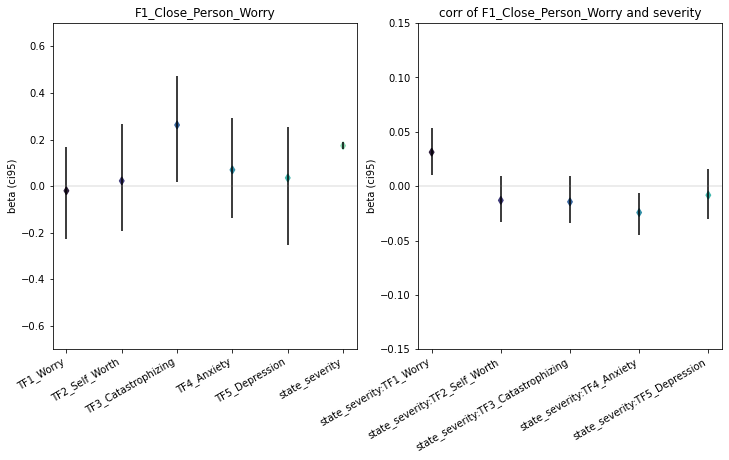

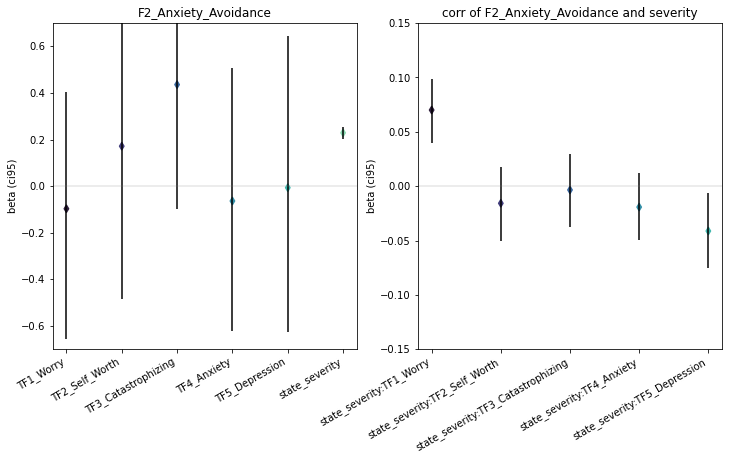

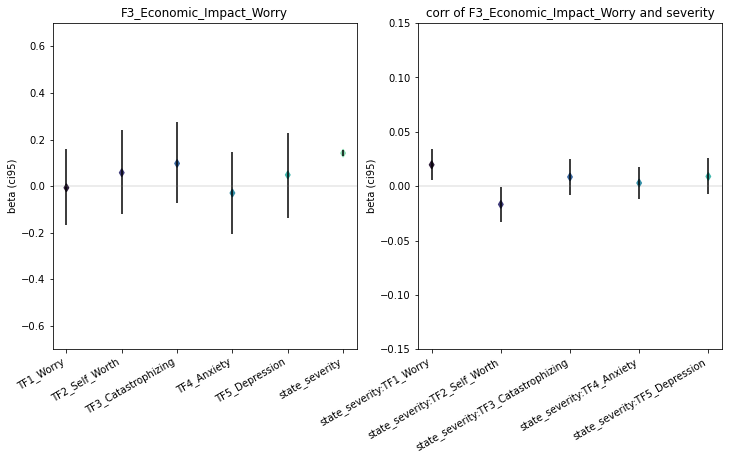

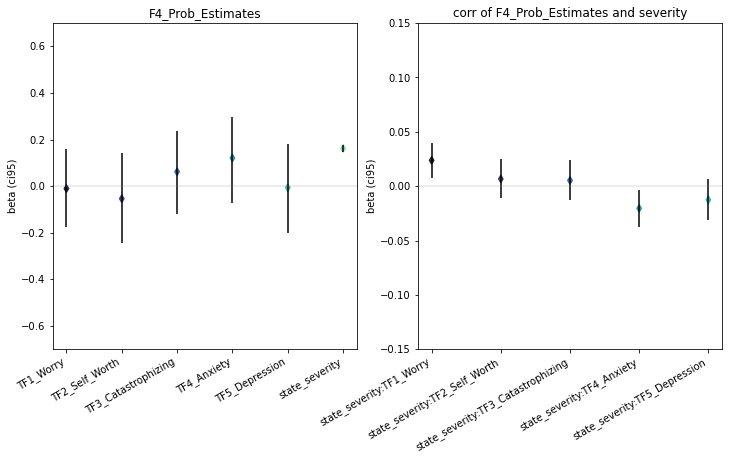

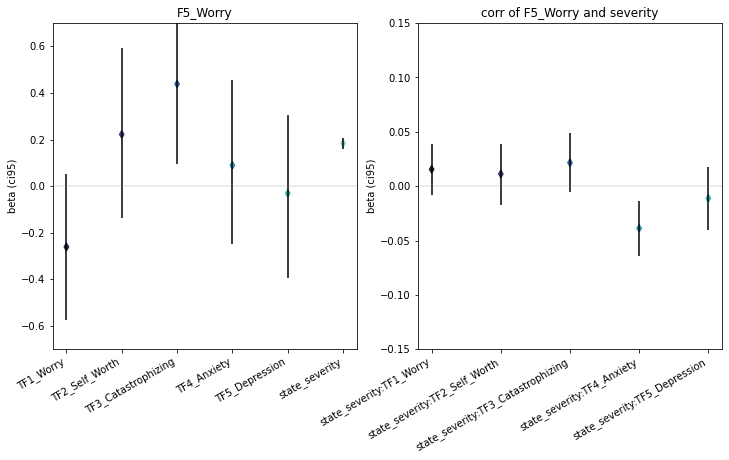

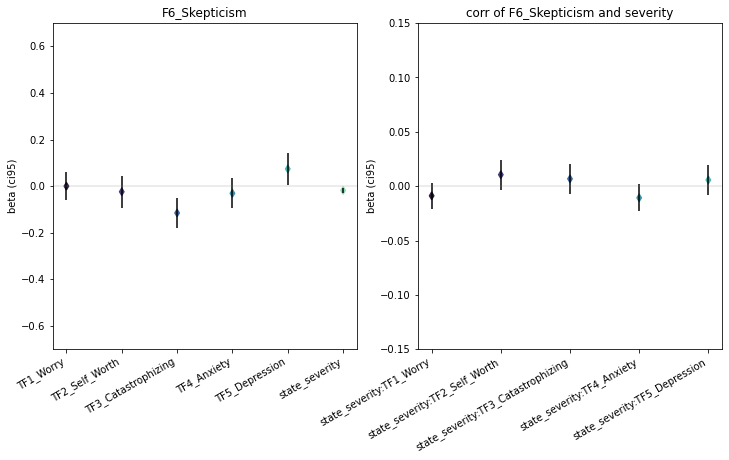

In [6]:
model_constant = "severity_onlysession_slope_f5"
ylims = [[-0.7,0.7], [-0.15, 0.15], [-0.02, 0.02]]
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_2000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    print(mod["current_sys_location"])
    mod, res,m  = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                        ['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
        axs[gr_idx].set_ylim(ylims[gr_idx])

### Model 1: traits + severity + traits * severity + (session|ID)
e.g.
$$
Worry \sim  Severity + TF_1 + TF_1*Severity  + TF_2 + TF_2*Severity + (session|subject) 
$$

I also fitted this in R and the results are nearly identical

In [ ]:
trait_factor_names+['state_severity']
# include state severity in the model !
#["state_severity"]+trait_factor_names+['state_severity*'+i for i in trait_factor_names]
df.loc[:,trait_factor_names+['state_severity']].describe().T


In [ ]:
from IPython import display
#factors_temp = ["F1_Close_Person_Worry"]
model_constant = "severity_noslope_ND"
estimate1 = 0
if estimate1:
    for f_idx, f in enumerate(factors): 
        dfl = df.loc[:,[f, "state_severity", "PROLIFICID", "session"]+trait_factor_names].dropna()
        models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
        if "F"+str(f_idx+1)+"_"+model_constant+"_2_3000" in models.keys():
            mod = models["F"+str(f_idx+1)+"_"+model_constant+"_2_3000"]
        else:
            mod = mm.get_template()
        mod["type"] = "lmm"
        mod["lmm"]["dep_var"] = f
        mod["lmm"]["fxeff"] = ["state_severity"]+trait_factor_names+['state_severity*'+i for i in trait_factor_names]
        mod["lmm"]["rneff"] = ["session|PROLIFICID"]
        mod["est"]["nchains"] = 2
        mod["est"]["nsamples"] = 3000
        mod["est"]["ncores"] = 2
        mod["name"] = "F"+str(f_idx+1)+"_"+model_constant+"_"+str(mod["est"]["nchains"])+"_"+str(mod["est"]["nsamples"])
        mod["lmm"]["eq"] = mm.generate_equation(mod["lmm"]["dep_var"], mod["lmm"]["fxeff"], mod["lmm"]["rneff"]) 
        mod["location"] = os.path.join("output", "models", "model_data", "traits_predicting_severity_correlations", mod["name"]+".dic" )
        mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
        mod, res, m = mm.estimate_lmm(mod=mod, data=dfl, override=0)
        models[mod["name"]] = mod
        print(mod["lmm"]["eq"])
        mm.save_model_info(models, os.path.join(root_dir, "output", "models", "model_database.json"))
    



In [ ]:
model_constant = "severity_noslope_ND"
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    mod, res, m = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")

In [ ]:
from IPython import display
pd.set_option('display.max_rows', 500)
results_table = az.summary(res)
results_table.head(20)
# model comparison, nesting might not makes sense, sess only 1 data point
#sess into slpe
m

### With random slopes


#### How to best structure the random effects structure

Simplified example, if we had only two trait factors $TF_1$ and $TF_2$. 
$St$ = state severity

Model 1 (above) ("noslopes")
$$
Worry \sim St + TF_1 + St*TF_1 + TF_2 + St*TF_2 + (sess| id) 
$$



Model 2 - with slopes

$$
Worry \sim St + TF_1 + St*TF_1 + TF_2 + St*TF_2 + (1 + TF_1 + TF_2 + sess | id) 
$$

Model 3 - also with interaction slopes

$$
Worry \sim St + TF_1 + St*TF_1 + TF_2 + St*TF_2 + (1 + TF_1 + St*TF_1 + TF_2 + St*TF_2 + sess | id) 
$$


Model 4  
The random slopes for traits didn't make sense beacuse they are fixed within participant.
What does make sense thought is to model the session as var of interest

$$
Worry \sim St + TF_1 + St*TF_1 + TF_2 + St*TF_2 + TF_1*sess + St*TF_1*sess + TF_2*sess + St*TF_2*sess + (1 + sess | id) 
$$



### Model 2: random slopes  severity + trait + severity\*trait + (1 + trait + session|subject)

In [ ]:
model_constant = "severity_slopes_ND"
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    mod, res, m = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.03,0.97)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")

### Model 3: random slopes and interactions  severity + trait + severity\*trait + (1 + trait + session + trait\*severity|subject)

In [ ]:

model_constant = "severity_maxmodel_ND"
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    mod, res, m = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")

### Model4: No random slopes (except session) but session as fixed    
### *severity + trait + trait\*sess + (sess|subejct)*


In [ ]:
ylims = [[-1,1], [-0.3, 0.3], [-0.02, 0.02]]
model_constant = "severity_slopes_and_session_ND"
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    print(mod["current_sys_location"])
    mod, res, m = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                        ['state_severity:'+i for i in trait_factor_names],
                                        ['state_severity:'+i+":session" for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
        axs[gr_idx].set_ylim(ylims[gr_idx])

### Model comparison 

**NOTE (!)** higher WAIC/LOO values are better - see Vehtari et al 2017 or https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html#arviz.compare 


In [ ]:
model_constants = ["severity_noslope",  "severity_maxmodel"]
folder = "traits_predicting_severity_correlations"
models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
for f_idx, f in enumerate(factors):    
    mod1 = models["F"+str(f_idx+1)+"_severity_noslope_ND_4_3000"]
    mod1["current_sys_location"] = os.path.join(root_dir, mod1["location"])
    mod1, res_m1, m = mm.estimate_lmm(mod1, [], override=0)
    
    mod2 = models["F"+str(f_idx+1)+"_severity_slopes_ND_4_3000"]
    mod2["current_sys_location"] = os.path.join(root_dir, mod2["location"])
    mod2, res_m2, m = mm.estimate_lmm(mod2, [], override=0)
    
    mod3 = models["F"+str(f_idx+1)+"_severity_maxmodel_ND_4_3000"]
    mod3["current_sys_location"] = os.path.join(root_dir, mod3["location"])
    mod3, res_m3, m = mm.estimate_lmm(mod3, [], override=0)
    
    mod4 = models["F"+str(f_idx+1)+"_severity_slopes_and_session_ND_4_3000"]
    mod4["current_sys_location"] = os.path.join(root_dir, mod4["location"])
    mod4, res_m4, m = mm.estimate_lmm(mod4, [], override=0)
    
    comp = az.compare({"noslopes": res_m1, "slopes": res_m2, "maximal": res_m3, "session_ints": res_m4}, ic="waic",method="pseudo-BMA")
    display.display(comp)
    az.plot_compare(comp, insample_dev=False);

### example of prior distributions

In [ ]:
eq = mod["lmm"]["eq"]
m = bmb.Model(eq, dfl, family="gaussian", link="identity")
m.build()
prior = m.prior_predictive(1000)

In [ ]:
# plot prior
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                    ['state_severity:'+i for i in trait_factor_names],
                                    ['state_severity:'+i+":session" for i in trait_factor_names]]):
    tdf = pd.DataFrame()
    for tf in beta_group:
        d = prior.prior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf
    axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs[gr_idx].axhline(0, alpha=0.2, color='gray')
    if gr_idx == 0:
        axs[gr_idx].set_title(f)
    elif gr_idx == 1:
        axs[gr_idx].set_title("corr of "+f+" and severity")
    axs[gr_idx].set_ylabel("beta (ci95)")
    axs[gr_idx].set_xlabel("")
    axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
    #axs[gr_idx].set_ylim(ylims[gr_idx])